In [1]:
import requests
import json

#import googlemaps
from itertools import tee

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

%matplotlib inline
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.patches import Rectangle
import math
import re
import os
from requests import get
from urllib.parse import urlparse
import io

from scipy import stats

from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar

from sklearn.metrics.pairwise import haversine_distances

import networkx as nx

# Load Data

https://tubecreature.com/#/map/current/same/U/940GZZLUGBY/FFTTTF/10.656624341094696/-0.2467/51.5403/

In [2]:
London = gpd.read_file('./data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
#commute_time=pd.read_csv('./data/travel_time_usual.csv')
#commute_time_strike=pd.read_csv('./data/travel_time_without_metro_2011.csv')
#commute_time_strike=pd.read_csv('./data/travel_time_tube_strike.csv')
#commute_time_strike_tram=pd.read_csv('./data/travel_time_rail_strike.csv')
commute_time=pd.read_csv('./data/travel_time/usual_travel_time.csv')
commute_time_strike=pd.read_csv('./data/travel_time/tube_strike_travel_time.csv')
commute_time_strike_tram=pd.read_csv('./data/travel_time/tram_strike_travel_time.csv')
lines = gpd.read_file('data/tfl_lines.json')

In [3]:
commuter_age=pd.read_csv('./data/WU02UK_msoa_v2/wu02uk_msoa_v2.csv', 
                         names=['Area of residence', 'Area of workplace','All categories: Age 16 and over',
                               '16-24', '25-34', '35-49', '50-64', '65-74', '75+'])

commuter_industry=pd.read_csv('./data/WU06BUK_msoa_v1/wu06buk_msoa_v1.csv',
                             names=['Area of usual residence', 'Area of workplace', 'All categories: Industry',
                                   'Agriculture, forestry and fishing', 'Mining  and quarrying', 'Manufacturing',
                                   'Electricity, gas, steam and air conditioning supply', 'Water supply; sewerage, waste management and remediation activities',
                                   'Construction', 'Wholesale and retail trade; repair of motor vehicles and motorcycles',
                                   'Transport and storage', 'Accommodation and food service activities', 'Information and communication',
                                   'Financial and insurance activities', 'Real estate activities', 'Professional, scientific and technical activities',
                                   'Administrative and support service activities', 'Public administration and defence; compulsory social security',
                                   'Education', 'Human health and social work activities', 'Arts, entertainment and recreation',
                                   'Other service activities', 'Activities of household as employers; undifferentiated goods - and services - producing activities of households for own use',
                                   'Activities of extraterritorial organisations and bodies'])

commuter_occupation=pd.read_csv('./data/WU07AUK_msoa_v1/wu07auk_msoa_v1.csv', 
                                names=['Area of usual residence', 'Area of workplace', 'All categories: Occupation',
                                      'Managers, directors and senior officials', 'Professional occupations', 'Associate professional and technical occupations',
                                      'Administrative and secretarial occupations', 'Skilled trades occupations', 'Caring, leisure and other service occupations',
                                      'Sales and customer service occupations', 'Process, plant and machine operatives', 'Elementary occupations'])

# Pre-process Data

In [4]:
London=London.to_crs(epsg=4326)
London_MSOA=London.loc[:,['MSOA11CD', 'MSOA11NM']]
London_MSOA_list=list(London_MSOA['MSOA11CD'])
London['centre']=London.to_crs('+proj=cea').centroid.to_crs(epsg=4326)
London['centre_lat'] = London.centre.apply(lambda p: p.y)
London['centre_lon'] = London.centre.apply(lambda p: p.x)
London.head()

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,centre,centre_lat,centre_lon
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((-0.10414 51.50841, -0.10444 51...",POINT (-0.09213 51.51482),51.514821,-0.092128
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((0.14809 51.59678, 0.14806 51.59640, ...",POINT (0.13947 51.58827),51.588271,0.139475
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((0.15063 51.58306, 0.14838 51.58075, ...",POINT (0.14090 51.57492),51.574925,0.140897
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((0.18508 51.56480, 0.18400 51.56391, ...",POINT (0.17683 51.55548),51.555476,0.176828
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((0.14988 51.56807, 0.15076 51.56778, ...",POINT (0.14332 51.56142),51.561420,0.143324


In [5]:
lines['mode']=lines['lines']
for i in range(0, lines.shape[0]):
    lines_dict=json.loads(lines.iloc[i,1])
    lines.loc[i,'mode']=lines_dict[0]['name']
    
lines.head()

,id,lines,geometry,mode
0,LeaValleyLine1,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (-0.05941 51.52391, -0.05910 51.523...",London Overground
1,LeaValleyLine2,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (-0.05760 51.53245, -0.05767 51.532...",London Overground
2,LeaValleyLine3,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (-0.05785 51.54118, -0.05780 51.541...",London Overground
3,LeaValleyLine4,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (-0.06116 51.54909, -0.06122 51.549...",London Overground
4,LeaValleyLine5,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (-0.06845 51.55866, -0.06868 51.559...",London Overground


In [6]:
tube=['Bakerloo', 'Central', 'Circle', 'District', 'Hammersmith & City', 'Jubilee', 'Metropolitan', 'Northern', 'Piccadilly', 'Victoria', 'Waterloo & City']
lines_tube=lines[lines['mode'].isin(tube)]
lines_tube = lines_tube.to_crs(epsg=4326)
clipped_London_tube = gpd.overlay(lines_tube, London, how='intersection')

In [7]:
lines_rail=lines[~(lines['mode'].isin(tube))]
lines_rail = lines_rail.to_crs(epsg=4326)
clipped_London_rail = gpd.overlay(lines_rail, London, how='intersection')

In [8]:
commute_time=commute_time.rename(columns={'from_id':'Origin_MSOACD',
                                         'to_id':'Destination_MSOACD'})
commute_time = pd.merge(commute_time, London_MSOA, left_on=['Origin_MSOACD'], right_on=['MSOA11CD'])
commute_time=commute_time.rename(columns={'MSOA11NM':'Origin_MSOANM'})
commute_time=commute_time.drop(['MSOA11CD'], axis=1)
commute_time = pd.merge(commute_time, London_MSOA, left_on=['Destination_MSOACD'], right_on=['MSOA11CD'])
commute_time=commute_time.rename(columns={'MSOA11NM':'Destination_MSOANM'})
commute_time=commute_time.drop(['MSOA11CD'], axis=1)

order=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM', 'travel_time_p50']
commute_time=commute_time[order]
commute_time.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,travel_time_p50
0,E02000001,City of London 001,E02000001,City of London 001,0.0
1,E02000269,Ealing 032,E02000001,City of London 001,58.0
2,E02000213,Croydon 020,E02000001,City of London 001,51.0
3,E02000487,Havering 024,E02000001,City of London 001,63.0
4,E02000065,Bexley 001,E02000001,City of London 001,55.0


In [9]:
commute_time_strike=commute_time_strike.rename(columns={'from_id':'Origin_MSOACD',
                                         'to_id':'Destination_MSOACD'})
commute_time_strike = pd.merge(commute_time_strike, London_MSOA, left_on=['Origin_MSOACD'], right_on=['MSOA11CD'])
commute_time_strike=commute_time_strike.rename(columns={'MSOA11NM':'Origin_MSOANM'})
commute_time_strike=commute_time_strike.drop(['MSOA11CD'], axis=1)
commute_time_strike = pd.merge(commute_time_strike, London_MSOA, left_on=['Destination_MSOACD'], right_on=['MSOA11CD'])
commute_time_strike=commute_time_strike.rename(columns={'MSOA11NM':'Destination_MSOANM'})
commute_time_strike=commute_time_strike.drop(['MSOA11CD'], axis=1)

order=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM', 'travel_time_p50']
commute_time_strike=commute_time_strike[order]
commute_time_strike.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,travel_time_p50
0,E02000001,City of London 001,E02000001,City of London 001,0.0
1,E02000269,Ealing 032,E02000001,City of London 001,60.0
2,E02000213,Croydon 020,E02000001,City of London 001,55.0
3,E02000487,Havering 024,E02000001,City of London 001,64.0
4,E02000065,Bexley 001,E02000001,City of London 001,56.0


In [10]:
commute_time_strike_tram=commute_time_strike_tram.rename(columns={'from_id':'Origin_MSOACD',
                                         'to_id':'Destination_MSOACD'})
commute_time_strike_tram = pd.merge(commute_time_strike_tram, London_MSOA, left_on=['Origin_MSOACD'], right_on=['MSOA11CD'])
commute_time_strike_tram=commute_time_strike_tram.rename(columns={'MSOA11NM':'Origin_MSOANM'})
commute_time_strike_tram=commute_time_strike_tram.drop(['MSOA11CD'], axis=1)
commute_time_strike_tram = pd.merge(commute_time_strike_tram, London_MSOA, left_on=['Destination_MSOACD'], right_on=['MSOA11CD'])
commute_time_strike_tram=commute_time_strike_tram.rename(columns={'MSOA11NM':'Destination_MSOANM'})
commute_time_strike_tram=commute_time_strike_tram.drop(['MSOA11CD'], axis=1)

order=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM', 'travel_time_p50']
commute_time_strike_tram=commute_time_strike_tram[order]
commute_time_strike_tram.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,travel_time_p50
0,E02000001,City of London 001,E02000001,City of London 001,0.0
1,E02000269,Ealing 032,E02000001,City of London 001,63.0
2,E02000213,Croydon 020,E02000001,City of London 001,86.0
3,E02000487,Havering 024,E02000001,City of London 001,75.0
4,E02000065,Bexley 001,E02000001,City of London 001,77.0


In [11]:
commute_time=commute_time.rename(columns={'travel_time_p50':'commute_time_usual'})
commute_time_strike=commute_time_strike.rename(columns={'travel_time_p50':'commute_time_strike_tube'})
commute_time_strike_tram=commute_time_strike_tram.rename(columns={'travel_time_p50':'commute_time_strike_tram'})
commute_time_com = commute_time.merge(commute_time_strike, on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'])
commute_time_com = commute_time_com.merge(commute_time_strike_tram, on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'])
commute_time_com

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,commute_time_usual,commute_time_strike_tube,commute_time_strike_tram
0,E02000001,City of London 001,E02000001,City of London 001,0.0,0.0,0.0
1,E02000269,Ealing 032,E02000001,City of London 001,58.0,60.0,63.0
2,E02000213,Croydon 020,E02000001,City of London 001,51.0,55.0,86.0
3,E02000487,Havering 024,E02000001,City of London 001,63.0,64.0,75.0
4,E02000065,Bexley 001,E02000001,City of London 001,55.0,56.0,77.0
...,...,...,...,...,...,...,...
1364494,E02000952,Wandsworth 030,E02000364,Hackney 020,58.0,83.0,64.0
1364495,E02000275,Ealing 038,E02000364,Hackney 020,71.0,71.0,112.0
1364496,E02000978,Westminster 019,E02000364,Hackney 020,42.0,59.0,50.0
1364497,E02000436,Harrow 004,E02000364,Hackney 020,86.0,87.0,98.0


In [12]:
commute_time_com['commute_time_difference_tube']=commute_time_com['commute_time_strike_tube']-commute_time_com['commute_time_usual']
commute_time_com['commute_time_difference_tram']=commute_time_com['commute_time_strike_tram']-commute_time_com['commute_time_usual']
commute_time_com.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,commute_time_usual,commute_time_strike_tube,commute_time_strike_tram,commute_time_difference_tube,commute_time_difference_tram
0,E02000001,City of London 001,E02000001,City of London 001,0.0,0.0,0.0,0.0,0.0
1,E02000269,Ealing 032,E02000001,City of London 001,58.0,60.0,63.0,2.0,5.0
2,E02000213,Croydon 020,E02000001,City of London 001,51.0,55.0,86.0,4.0,35.0
3,E02000487,Havering 024,E02000001,City of London 001,63.0,64.0,75.0,1.0,12.0
4,E02000065,Bexley 001,E02000001,City of London 001,55.0,56.0,77.0,1.0,22.0


# Analysis

## Statistical presentation

In [13]:
commute_rank=commute_time_com.copy()
#commute_rank=commute_rank.sort_values('commute_time_difference', ascending=True)
commute_rank=commute_rank[commute_rank['commute_time_difference_tube']<0]
commute_rank

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,commute_time_usual,commute_time_strike_tube,commute_time_strike_tram,commute_time_difference_tube,commute_time_difference_tram
31,E02000371,Hackney 027,E02000001,City of London 001,23.0,21.0,23.0,-2.0,0.0
32,E02000371,Hackney 027,E02000001,City of London 001,23.0,21.0,20.0,-2.0,-3.0
55,E02000726,Newham 013,E02000001,City of London 001,38.0,37.0,39.0,-1.0,1.0
56,E02000726,Newham 013,E02000001,City of London 001,38.0,37.0,36.0,-1.0,-2.0
57,E02000726,Newham 013,E02000001,City of London 001,38.0,37.0,37.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...
1364311,E02000257,Ealing 020,E02000364,Hackney 020,62.0,55.0,73.0,-7.0,11.0
1364386,E02000780,Redbridge 030,E02000364,Hackney 020,56.0,49.0,76.0,-7.0,20.0
1364387,E02000780,Redbridge 030,E02000364,Hackney 020,56.0,49.0,69.0,-7.0,13.0
1364484,E02000291,Enfield 015,E02000364,Hackney 020,55.0,52.0,83.0,-3.0,28.0


In [14]:
pd.set_option('display.float_format', '{:.6f}'.format)
commute_time_com.describe()

,commute_time_usual,commute_time_strike_tube,commute_time_strike_tram,commute_time_difference_tube,commute_time_difference_tram
count,1364499.000000,1364463.000000,1363898.000000,1364463.000000,1363898.000000
mean,70.483317,81.245313,86.499883,10.763934,16.041605
std,23.388470,28.632742,36.969868,12.684852,19.984965
min,0.000000,0.000000,0.000000,-24.000000,-22.000000
25%,54.000000,61.000000,60.000000,1.000000,1.000000
50%,70.000000,80.000000,81.000000,7.000000,9.000000
75%,86.000000,99.000000,107.000000,17.000000,24.000000
max,233.000000,239.000000,239.000000,135.000000,163.000000


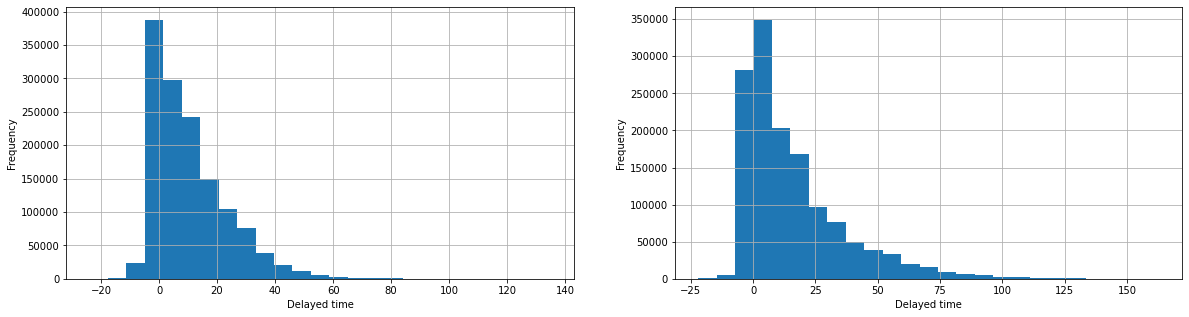

In [15]:
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
commute_time_com['commute_time_difference_tube'].hist(bins=25, ax=axes[0])
axes[0].set_xlabel('Delayed time')
axes[0].set_ylabel('Frequency')
commute_time_com['commute_time_difference_tram'].hist(bins=25, ax=axes[1])
axes[1].set_xlabel('Delayed time')
axes[1].set_ylabel('Frequency')
plt.show()

In [16]:
commute_time_strike_tube_mean=commute_time_com.groupby(by='Origin_MSOACD').mean()
commute_time_strike_tube_mean=commute_time_strike_tube_mean.loc[:,['commute_time_difference_tube']]
commute_time_strike_tube_mean=commute_time_strike_tube_mean.reset_index()
commute_time_strike_tube_des_mean=commute_time_com.groupby(by='Destination_MSOACD').mean()
commute_time_strike_tube_des_mean=commute_time_strike_tube_des_mean.loc[:,['commute_time_difference_tube']]
commute_time_strike_tube_des_mean=commute_time_strike_tube_des_mean.reset_index()
commute_time_strike_tube_mean.head()

,Origin_MSOACD,commute_time_difference_tube
0,E02000001,8.078632
1,E02000002,6.796902
2,E02000003,4.544130
3,E02000004,6.632075
4,E02000005,4.735445


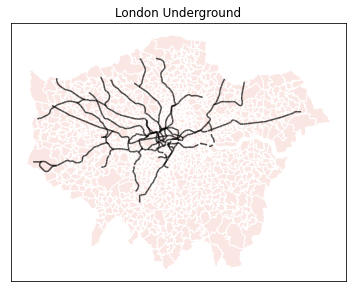

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
London.plot(facecolor='#FAE7E3', edgecolor='white', ax=ax)
clipped_London_tube.plot(color='black', alpha=0.7, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('London Underground')
plt.show()

https://stackoverflow.com/questions/70256031/how-do-you-display-the-scale-in-meters-the-north-arrow-and-the-axes-in-latitude

In [18]:
A=[-0.09213*np.pi/180.,51.51482*np.pi/180.] #Latitude of interest here 40.7 deg, longitude -74.5
B=[-1.09213*np.pi/180.,51.51482*np.pi/180.] ##Latitude of interest here 40.7 deg, longitude -74.5+1
dx=(6371000)*haversine_distances([A,B])[0,1]

## Spatial distribution of delays due to the strike

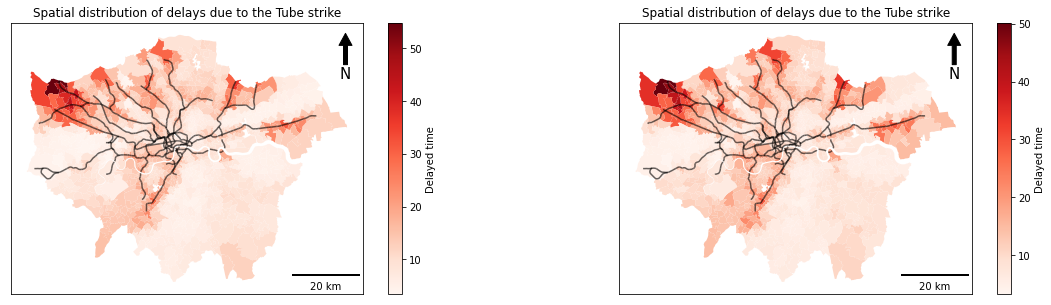

In [19]:
x, y, arrow_length = 0.95, 0.96, 0.15

commute_time_strike_tube_mean_geo=pd.merge(London, commute_time_strike_tube_mean, left_on='MSOA11CD', right_on='Origin_MSOACD')
commute_time_strike_tube_des_mean_geo=pd.merge(London, commute_time_strike_tube_des_mean, left_on='MSOA11CD', right_on='Destination_MSOACD')
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)


#commute_time_strike_mean_geo.plot(column=commute_time_strike_mean_geo['commute_time_difference_p25'], legend= True, cmap='Reds', ax=axes[0])
commute_time_strike_tube_mean_geo.plot(column=commute_time_strike_tube_mean_geo['commute_time_difference_tube'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
#lines.plot(color='black', alpha=0.4, ax=axes[0])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time')


test=commute_time_strike_tube_mean_geo.plot(column=commute_time_strike_tube_des_mean_geo['commute_time_difference_tube'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time')


In [20]:
commute_time_strike_tram_mean=commute_time_com.groupby(by='Origin_MSOACD').mean()
commute_time_strike_tram_mean=commute_time_strike_tram_mean.loc[:,['commute_time_difference_tram']]
commute_time_strike_tram_mean=commute_time_strike_tram_mean.reset_index()
commute_time_strike_tram_des_mean=commute_time_com.groupby(by='Destination_MSOACD').mean()
commute_time_strike_tram_des_mean=commute_time_strike_tram_des_mean.loc[:,['commute_time_difference_tram']]
commute_time_strike_tram_des_mean=commute_time_strike_tram_des_mean.reset_index()
commute_time_strike_tram_mean.head()

,Origin_MSOACD,commute_time_difference_tram
0,E02000001,9.113675
1,E02000002,12.110155
2,E02000003,24.957940
3,E02000004,14.524957
4,E02000005,17.748072


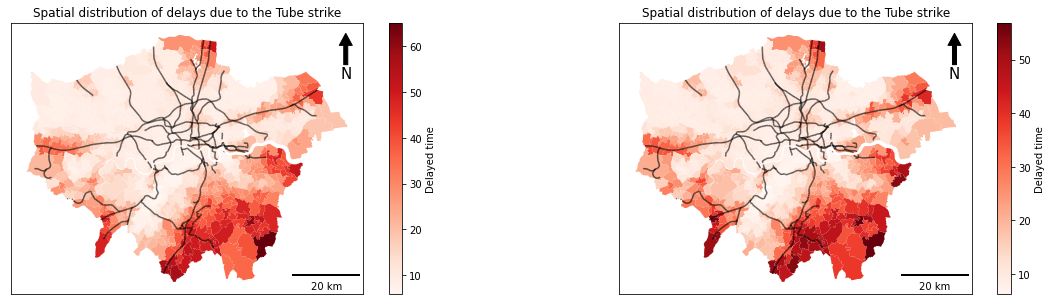

In [21]:
commute_time_strike_tram_mean_geo=pd.merge(London, commute_time_strike_tram_mean, left_on='MSOA11CD', right_on='Origin_MSOACD')
commute_time_strike_tram_des_mean_geo=pd.merge(London, commute_time_strike_tram_des_mean, left_on='MSOA11CD', right_on='Destination_MSOACD')
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
#commute_time_strike_mean_geo.plot(column=commute_time_strike_mean_geo['commute_time_difference_p25'], legend= True, cmap='Reds', ax=axes[0])

commute_time_strike_tram_mean_geo.plot(column=commute_time_strike_tram_mean_geo['commute_time_difference_tram'], legend= False, cmap='Reds', ax=axes[0])
clipped_London_rail.plot(color='black', alpha=0.6, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time')

commute_time_strike_tram_mean_geo.plot(column=commute_time_strike_tram_des_mean_geo['commute_time_difference_tram'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_rail.plot(color='black', alpha=0.6, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time')

## Consider the number of commuters

In [22]:
def collect_data(commuter_strategy):
    if list(commuter_strategy.columns) == ['Area of residence', 'Area of workplace','All categories: Age 16 and over', '16-24', '25-34', '35-49', '50-64', '65-74', '75+']:
        commuter_strategy = commuter_strategy.rename(columns={'Area of residence':'Area of usual residence'})
        
    commuter_strategy=commuter_strategy[commuter_strategy['Area of usual residence'].isin(London_MSOA_list)]
    commuter_strategy=commuter_strategy[commuter_strategy['Area of workplace'].isin(London_MSOA_list)]
    commuter_strategy=commuter_strategy.reset_index()
    
    columns_name=list(commuter_strategy.columns)[3:]
    
    commuter_strategy = pd.merge(commuter_strategy, London_MSOA, left_on=['Area of usual residence'], right_on=['MSOA11CD'])
    commuter_strategy=commuter_strategy.rename(columns={'MSOA11NM':'Residence_MSOANM'})
    commuter_strategy=commuter_strategy.drop(['MSOA11CD'], axis=1)
    
    commuter_strategy = pd.merge(commuter_strategy, London_MSOA, left_on=['Area of workplace'], right_on=['MSOA11CD'])
    commuter_strategy=commuter_strategy.rename(columns={'MSOA11NM':'Workplace_MSOANM'})
    commuter_strategy=commuter_strategy.drop(['MSOA11CD'], axis=1)
    
    order=['Area of usual residence', 'Residence_MSOANM', 'Area of workplace', 'Workplace_MSOANM'] + columns_name
    commuter_strategy=commuter_strategy[order]
    
    return commuter_strategy

In [23]:
commuter_age=collect_data(commuter_age)
commuter_age_strike = pd.merge(commute_time_com, commuter_age, left_on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'], 
                        right_on=['Area of usual residence', 'Residence_MSOANM', 'Area of workplace', 'Workplace_MSOANM'])

commuter_industry=collect_data(commuter_industry)
commuter_industry_strike = pd.merge(commute_time_com, commuter_industry, left_on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'], 
                        right_on=['Area of usual residence', 'Residence_MSOANM', 'Area of workplace', 'Workplace_MSOANM'])

commuter_occupation=collect_data(commuter_occupation)
commuter_occupation_strike = pd.merge(commute_time_com, commuter_occupation, left_on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'], 
                        right_on=['Area of usual residence', 'Residence_MSOANM', 'Area of workplace', 'Workplace_MSOANM'])

In [24]:
commuter_strike=commuter_age_strike.copy()
commuter_strike=commuter_strike[~(commuter_strike['Destination_MSOACD']==commuter_strike['Origin_MSOACD'])]

commuter_strike['Passenger_difference_tube']=commuter_strike['commute_time_difference_tube']*commuter_strike['All categories: Age 16 and over']
commuter_strike['Passenger_difference_tram']=commuter_strike['commute_time_difference_tram']*commuter_strike['All categories: Age 16 and over']

commuter_strike=commuter_strike.rename(columns={'All categories: Age 16 and over':'Passenger_number'})

order=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM' ,'commute_time_difference_tube', 'commute_time_difference_tram', 
       'Passenger_number', 'Passenger_difference_tube', 'Passenger_difference_tram']
commuter_strike=commuter_strike[order]
commuter_strike.describe()

,commute_time_difference_tube,commute_time_difference_tram,Passenger_number,Passenger_difference_tube,Passenger_difference_tram
count,579987.000000,579947.000000,579989.000000,579987.000000,579947.000000
mean,8.083781,10.396310,9.044337,51.806984,53.381183
std,10.473950,14.964233,27.866543,271.116817,247.040751
min,-24.000000,-20.000000,1.000000,-10346.000000,-10346.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000
50%,5.000000,5.000000,3.000000,11.000000,12.000000
75%,13.000000,15.000000,7.000000,37.000000,42.000000
max,134.000000,163.000000,1867.000000,26535.000000,30590.000000


### Average

In [25]:
tube_strike_sum = commuter_strike['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
ave_tube_delay

5.728093135296217

In [26]:
tram_strike_sum = commuter_strike['Passenger_difference_tram'].sum()
passenger_sum=commuter_strike['Passenger_number'].sum()
ave_tram_delay=tram_strike_sum/passenger_sum
ave_tram_delay

5.901739090318467

In [27]:
commuter_strike_sum_origin=commuter_strike.groupby(by='Origin_MSOACD').sum()
#commuter_strike_tube_sum_origin=commuter_strike_tube_sum_origin.loc[:,['Passenger_difference_tube', 'Passenger_number']]
commuter_strike_sum_origin['average_difference_tube']=commuter_strike_sum_origin['Passenger_difference_tube']/commuter_strike_sum_origin['Passenger_number']
commuter_strike_sum_origin['average_difference_tram']=commuter_strike_sum_origin['Passenger_difference_tram']/commuter_strike_sum_origin['Passenger_number']
commuter_strike_sum_origin=commuter_strike_sum_origin.loc[:,['average_difference_tube', 'average_difference_tram']]
commuter_strike_sum_origin=commuter_strike_sum_origin.reset_index(drop=False)

commuter_strike_sum_destination=commuter_strike.groupby(by='Destination_MSOACD').sum()
#commuter_strike_tube_sum_destination=commuter_strike_tube_sum_destination.reset_index(drop=False)
#commuter_strike_tube_sum_destination=commuter_strike_tube_sum_origin.loc[:,['Passenger_difference_tube', 'Passenger_number']]
commuter_strike_sum_destination['average_difference_tube']=commuter_strike_sum_destination['Passenger_difference_tube']/commuter_strike_sum_destination['Passenger_number']
commuter_strike_sum_destination['average_difference_tram']=commuter_strike_sum_destination['Passenger_difference_tram']/commuter_strike_sum_destination['Passenger_number']
commuter_strike_sum_destination=commuter_strike_sum_destination.loc[:,['average_difference_tube', 'average_difference_tram']]
commuter_strike_sum_destination=commuter_strike_sum_destination.reset_index(drop=False)

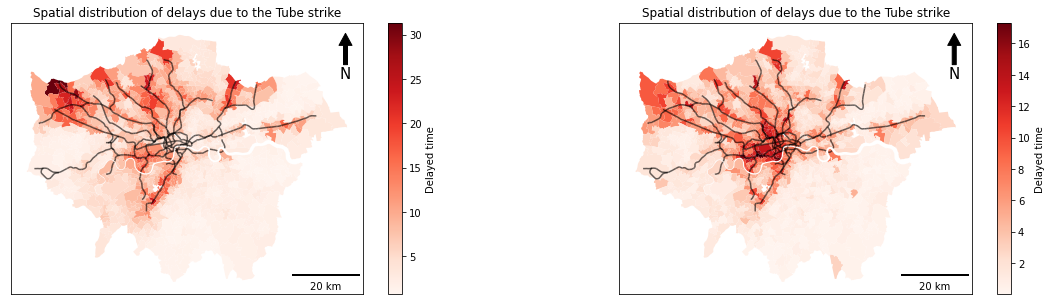

In [28]:
x, y, arrow_length = 0.95, 0.96, 0.15

commuter_strike_sum_origin_geo=pd.merge(London, commuter_strike_sum_origin, left_on='MSOA11CD', right_on='Origin_MSOACD')
commuter_strike_sum_destination_geo=pd.merge(London, commuter_strike_sum_destination, left_on='MSOA11CD', right_on='Destination_MSOACD')
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)


#commute_time_strike_mean_geo.plot(column=commute_time_strike_mean_geo['commute_time_difference_p25'], legend= True, cmap='Reds', ax=axes[0])
commuter_strike_sum_origin_geo.plot(column=commuter_strike_sum_origin['average_difference_tube'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
#lines.plot(color='black', alpha=0.4, ax=axes[0])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time')


commuter_strike_sum_destination_geo.plot(column=commuter_strike_sum_destination_geo['average_difference_tube'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time')

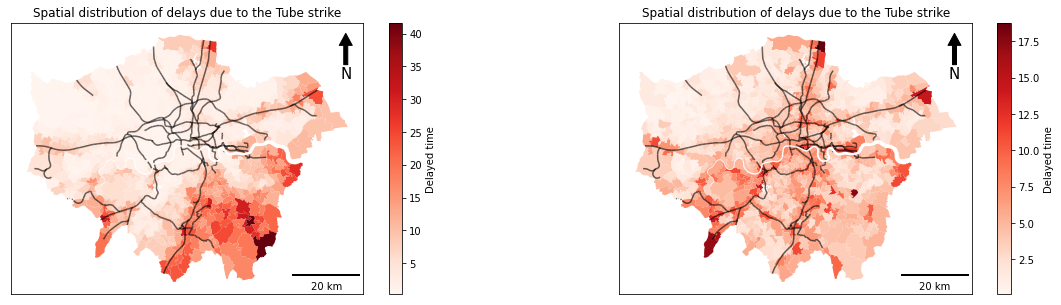

In [29]:
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)


#commute_time_strike_mean_geo.plot(column=commute_time_strike_mean_geo['commute_time_difference_p25'], legend= True, cmap='Reds', ax=axes[0])
commuter_strike_sum_origin_geo.plot(column=commuter_strike_sum_origin['average_difference_tram'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
#lines.plot(color='black', alpha=0.4, ax=axes[0])
clipped_London_rail.plot(color='black', alpha=0.6, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time')


commuter_strike_sum_destination_geo.plot(column=commuter_strike_sum_destination_geo['average_difference_tram'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_rail.plot(color='black', alpha=0.6, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time')

### Total

In [30]:
commuter_strike_mean_origin=commuter_strike.groupby(by='Origin_MSOACD').mean()
commuter_strike_mean_origin=commuter_strike_mean_origin.loc[:,['Passenger_difference_tube', 'Passenger_difference_tram']]
commuter_strike_mean_origin=commuter_strike_mean_origin.reset_index(drop=False)

commuter_strike_mean_destination=commuter_strike.groupby(by='Destination_MSOACD').mean()
commuter_strike_mean_destination=commuter_strike_mean_destination.loc[:,['Passenger_difference_tube', 'Passenger_difference_tram']]
commuter_strike_mean_destination=commuter_strike_mean_destination.reset_index(drop=False)

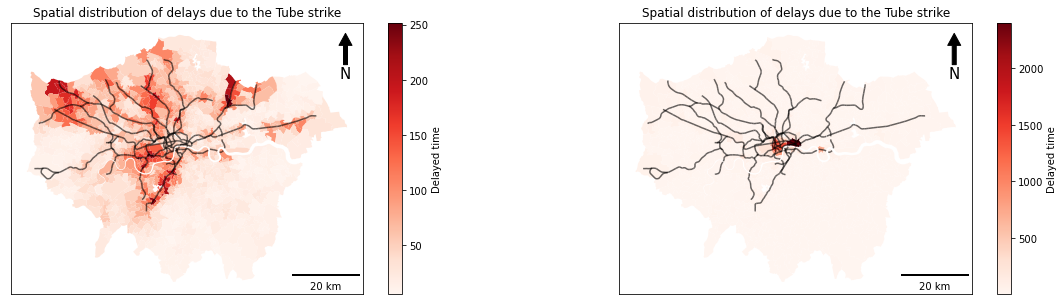

In [31]:
commuter_strike_mean_origin_geo=pd.merge(London, commuter_strike_mean_origin, left_on='MSOA11CD', right_on='Origin_MSOACD')
commuter_strike_mean_destination_geo=pd.merge(London, commuter_strike_mean_destination, left_on='MSOA11CD', right_on='Destination_MSOACD')


fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
commuter_strike_mean_origin_geo.plot(column=commuter_strike_mean_origin_geo['Passenger_difference_tube'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
#lines.plot(color='black', alpha=0.4, ax=axes[0])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time')


commuter_strike_mean_destination_geo.plot(column=commuter_strike_mean_destination_geo['Passenger_difference_tube'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time')

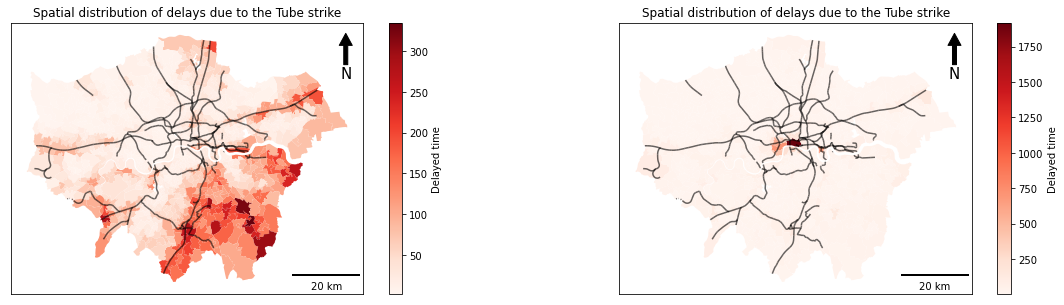

In [32]:
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
commuter_strike_mean_origin_geo.plot(column=commuter_strike_mean_origin_geo['Passenger_difference_tram'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
#lines.plot(color='black', alpha=0.4, ax=axes[0])
clipped_London_rail.plot(color='black', alpha=0.6, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time')


commuter_strike_mean_destination_geo.plot(column=commuter_strike_mean_destination_geo['Passenger_difference_tram'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_rail.plot(color='black', alpha=0.6, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time')

### Inner London and Outer London

In [33]:
inner_outer_London=gpd.read_file('./data/lp-falp-2006-inner-outer-london-shp/lp-falp-2006-inner-outer-london.shp')
central_london=gpd.read_file('./data/lp-falp-2006-central-activities-zone-shp/lp-falp-2006-central-activities-zone.shp')

In [34]:
central_london=central_london.to_crs(epsg=4326)

inner_london=inner_outer_London.iloc[[0],:]
inner_london=inner_london.to_crs(epsg=4326)
inner_london = gpd.overlay(inner_london, central_london, how='difference')

outer_london=inner_outer_London.iloc[[1],:]
outer_london=outer_london.to_crs(epsg=4326)

<AxesSubplot:>

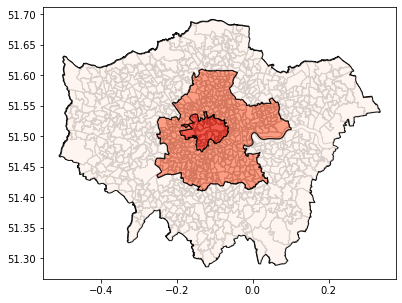

In [35]:
f,ax = plt.subplots(figsize=(10,5))
London.plot(facecolor='none', ax=ax)
central_london.plot(edgecolor='black', facecolor='#EE3D2E', linewidth=1, alpha=0.85, ax=ax)
inner_london.plot(edgecolor='black', facecolor='#FC8D6F', linewidth=1, alpha=0.85, ax=ax)
outer_london.plot(edgecolor='black', facecolor='#FFF4EE', linewidth=1, alpha=0.85, ax=ax)

In [36]:
central_london_bro = gpd.overlay( London, central_london,how='intersection')
central_london_bro=list(central_london_bro['MSOA11CD'])

inner_london_bro = gpd.overlay( London, inner_london,how='intersection')
inner_london_bro=list(inner_london_bro['MSOA11CD'])

outer_london_bro = gpd.overlay( London, outer_london,how='intersection')
outer_london_bro=list(outer_london_bro['MSOA11CD'])

In [37]:
commuter_strike_central_origin=commuter_strike[commuter_strike['Origin_MSOACD'].isin(central_london_bro)]
#commuter_strike_central_origin=commuter_strike_central_origin.reset_index()


commuter_strike_cc=commuter_strike_central_origin[commuter_strike_central_origin['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_cc=commuter_strike_cc.reset_index().drop(['index'], axis=1)

commuter_strike_ci=commuter_strike_central_origin[commuter_strike_central_origin['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_ci=commuter_strike_ci.reset_index().drop(['index'], axis=1)

commuter_strike_co=commuter_strike_central_origin[commuter_strike_central_origin['Destination_MSOACD'].isin(outer_london_bro)]
commuter_strike_co=commuter_strike_co.reset_index().drop(['index'], axis=1)

In [38]:
commuter_strike_inner_origin=commuter_strike[commuter_strike['Origin_MSOACD'].isin(inner_london_bro)]
#commuter_strike_central_origin=commuter_strike_central_origin.reset_index()


commuter_strike_ic=commuter_strike_inner_origin[commuter_strike_inner_origin['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_ic=commuter_strike_ic.reset_index().drop(['index'], axis=1)

commuter_strike_ii=commuter_strike_inner_origin[commuter_strike_inner_origin['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_ii=commuter_strike_ii.reset_index().drop(['index'], axis=1)

commuter_strike_io=commuter_strike_inner_origin[commuter_strike_inner_origin['Destination_MSOACD'].isin(outer_london_bro)]
commuter_strike_io=commuter_strike_io.reset_index().drop(['index'], axis=1)

In [39]:
commuter_strike_outer_origin=commuter_strike[commuter_strike['Origin_MSOACD'].isin(outer_london_bro)]
#commuter_strike_central_origin=commuter_strike_central_origin.reset_index()


commuter_strike_oc=commuter_strike_outer_origin[commuter_strike_outer_origin['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_oc=commuter_strike_oc.reset_index().drop(['index'], axis=1)

commuter_strike_oi=commuter_strike_outer_origin[commuter_strike_outer_origin['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_oi=commuter_strike_oi.reset_index().drop(['index'], axis=1)

commuter_strike_oo=commuter_strike_outer_origin[commuter_strike_outer_origin['Destination_MSOACD'].isin(outer_london_bro)]
commuter_strike_oo=commuter_strike_oo.reset_index().drop(['index'], axis=1)

In [40]:
delay_time_dict={}
delay_time_dict['origin_central']={}

tube_strike_sum = commuter_strike_cc['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_cc['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

tram_strike_sum = commuter_strike_cc['Passenger_difference_tram'].sum()
ave_tram_delay=tram_strike_sum/passenger_sum
ave_tram_delay

delay_time_dict['origin_central']['destination_central']={'tube':ave_tube_delay, 'tram':ave_tram_delay}


tube_strike_sum = commuter_strike_ci['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_ci['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

tram_strike_sum = commuter_strike_ci['Passenger_difference_tram'].sum()
ave_tram_delay=tram_strike_sum/passenger_sum
ave_tram_delay

delay_time_dict['origin_central']['destination_inner']={'tube':ave_tube_delay, 'tram':ave_tram_delay}


tube_strike_sum = commuter_strike_co['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_co['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

tram_strike_sum = commuter_strike_co['Passenger_difference_tram'].sum()
ave_tram_delay=tram_strike_sum/passenger_sum
ave_tram_delay

delay_time_dict['origin_central']['destination_outer']={'tube':ave_tube_delay, 'tram':ave_tram_delay}

In [41]:
delay_time_dict['origin_inner']={}

tube_strike_sum = commuter_strike_ic['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_ic['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

tram_strike_sum = commuter_strike_ic['Passenger_difference_tram'].sum()
ave_tram_delay=tram_strike_sum/passenger_sum
ave_tram_delay

delay_time_dict['origin_inner']['destination_central']={'tube':ave_tube_delay, 'tram':ave_tram_delay}


tube_strike_sum = commuter_strike_ii['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_ii['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

tram_strike_sum = commuter_strike_ii['Passenger_difference_tram'].sum()
ave_tram_delay=tram_strike_sum/passenger_sum
ave_tram_delay

delay_time_dict['origin_inner']['destination_inner']={'tube':ave_tube_delay, 'tram':ave_tram_delay}


tube_strike_sum = commuter_strike_io['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_io['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

tram_strike_sum = commuter_strike_io['Passenger_difference_tram'].sum()
ave_tram_delay=tram_strike_sum/passenger_sum
ave_tram_delay

delay_time_dict['origin_inner']['destination_outer']={'tube':ave_tube_delay, 'tram':ave_tram_delay}

In [42]:
delay_time_dict['origin_outer']={}

tube_strike_sum = commuter_strike_oc['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_oc['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

tram_strike_sum = commuter_strike_oc['Passenger_difference_tram'].sum()
ave_tram_delay=tram_strike_sum/passenger_sum
ave_tram_delay

delay_time_dict['origin_outer']['destination_central']={'tube':ave_tube_delay, 'tram':ave_tram_delay}


tube_strike_sum = commuter_strike_oi['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_oi['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

tram_strike_sum = commuter_strike_oi['Passenger_difference_tram'].sum()
ave_tram_delay=tram_strike_sum/passenger_sum
ave_tram_delay

delay_time_dict['origin_outer']['destination_inner']={'tube':ave_tube_delay, 'tram':ave_tram_delay}


tube_strike_sum = commuter_strike_oo['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_oo['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

tram_strike_sum = commuter_strike_oo['Passenger_difference_tram'].sum()
ave_tram_delay=tram_strike_sum/passenger_sum
ave_tram_delay

delay_time_dict['origin_outer']['destination_outer']={'tube':ave_tube_delay, 'tram':ave_tram_delay}

In [43]:
delay_time = pd.DataFrame(index=['origin_central', 'origin_inner', 'origin_outer'],
                       columns=[['destination_central', 'destination_central', 'destination_inner', 'destination_inner', 'destination_outer', 'destination_outer'], 
                                ['tube', 'tram', 'tube', 'tram', 'tube', 'tram']])

london_area=['central', 'inner', 'outer']
london_mode=['tube', 'tram']

for i in london_area:
    origin_area=f'origin_'+i
    for j in london_area:
        destination_area=f'destination_'+j
        for m in london_mode:
            delay_time.loc[origin_area, (destination_area, m)]=delay_time_dict[origin_area][destination_area][m]   

delay_time

destination_central           destination_inner           \
                              tube      tram              tube     tram   
origin_central            7.077518  0.306881          6.694546 1.446797   
origin_inner              8.290209  3.466211          5.032409 4.178714   
origin_outer              9.140883 10.771115          6.443078 9.372957   

               destination_outer           
                            tube     tram  
origin_central          7.997375 8.894510  
origin_inner            4.451186 6.717486  
origin_outer            2.461448 4.325001